# Applied Machine Learning - Exercise 2

Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

In [1]:
import pandas as pd                                     
import numpy as np                    

import matplotlib.pyplot as plt
from sklearn import metrics
import os                                         
import sklearn
import sklearn.cluster
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import seaborn as sns                                   # For pretty plots

In [2]:
data = pd.read_csv('data/players_cleaned_with_feature.csv')
data.head()

,playerShort,club,leagueCountry,birthday,position,redCards,meanIAT_yellowCards,height,victories,meanIAT_yellowReds,...,games,weight,goals,meanExp_redCards,skin_color,meanExp_yellowCards,meanExp_yellowReds,yellowCards,ties,defeats
0,aaron-hughes,Fulham FC,England,3598.0,Center Back,0,-0.034618,182.0,247,-0.001343,...,654,71.0,9,-0.020220,0.125,-0.040843,-0.001615,19,179,228
1,aaron-hunt,Werder Bremen,Germany,6090.0,Attacking Midfielder,1,-0.002753,183.0,141,-0.001376,...,336,73.0,62,0.000029,0.125,-0.002366,-0.001535,42,73,122
2,aaron-lennon,Tottenham Hotspur,England,6314.0,Right Midfielder,0,-0.035463,165.0,200,-0.001340,...,412,63.0,31,-0.020464,0.250,-0.042534,-0.001610,11,97,115
3,aaron-ramsey,Arsenal FC,England,7664.0,Center Midfielder,1,-0.004654,178.0,150,-0.001357,...,260,76.0,39,-0.008712,0.000,-0.006586,-0.001747,31,42,68
4,abdelhamid-el-kaoutari,Montpellier HSC,France,7380.0,Center Back,2,-0.022667,180.0,41,0.009606,...,124,73.0,1,0.020312,0.250,-0.022177,0.010400,8,40,43


## Data treatment
The data treatment is the same as in Exercise 1.

### Skin color

In order to perform the classification, we need to determine how much label categories we want. We choose to separate the skin_color of the players in only two groups that we'll call white and black.   

In [3]:
data["skin_color"] = data["skin_color"].apply(lambda x: 0 if x <=0.5 else 1)
data.groupby(["skin_color"])["skin_color"].count()

skin_color
0    1203
1     230
Name: skin_color, dtype: int64

### Nan values

We still have some unknown height and weight values in our data, so we drop them.

In [4]:
data = data.dropna()

### Numerization of string values

In order to use the the features with string values, we need to convert them to numerical values. We will just assign the same integer to every same values.

We start with the players position:

In [5]:
for feature in ["position","leagueCountry","club"]:
    num, labels = pd.factorize(data[feature])
    data[feature] = num

We don't need the names of the players, so we simply drop them.

In [6]:
data = data.drop("playerShort", axis=1)

## Clustering of the data using k_means
Since the goal is to determine if well defined separated clusters can also separate black people and white people well, only 2 clusters are used. Using the following function, the data is clustered into 2 clusters using all the features present in 'data'. The k_means function uses the k-means++ initialization method to try different starting centroids rather than picking a random one. This is very important since the initial set of centroids has a big influence on the effectiveness of the k_means algorithm.

The silhouette score is calculated on the resulting clusters to assess the qualilty of the clustering (if the points in different clusters are well separated from each other and if the points in the same clusters are close from each others). The quality of the separation of white and black people, called 'skin_color_repartition' is also calculated on the clusters by assigning the appropriate skin color to each cluster and checking the proportion of people that are assigned to the correct cluster given their skin color. This ranges from 0.5 if only 50% of the people are assigned correctly, which means the repartition is completely independant from the skin color and 1 if everyone is assigned in the right cluster.

The function returns the silhouette score, the skin color repartition and the centroids corresponding to each skin color.

In [7]:
def kmeans(data):
    n_clusters = 2
    data_no_skin = data.drop('skin_color', axis=1)
    kmeans_results = sklearn.cluster.k_means(data_no_skin, n_clusters, init='k-means++', precompute_distances='auto', n_init=10, max_iter=300, verbose=False, tol=0.0001, random_state=None, copy_x=True, n_jobs=1, return_n_iter=True)
    labels = kmeans_results[1]
    silhouette_score = sklearn.metrics.silhouette_score(data_no_skin, labels)
    labels_series = pd.Series(labels)
    comparison = labels_series == data['skin_color']
    true = comparison[lambda x: x == True].size
    false = comparison.size - true
    if(true > false):
        white_centroid = kmeans_results[0][0]
        black_centroid = kmeans_results[0][1]
        skin_color_repartition = true/comparison.size
    else:
        white_centroid = kmeans_results[0][1]
        black_centroid = kmeans_results[0][0]
        skin_color_repartition = false/comparison.size
    return silhouette_score, skin_color_repartition, white_centroid, black_centroid

### Search of the optimal features
To obtain more interesting results, the skin_color feature is removed for the clustering process since it would be too easy to obtain a good separation of the white and black players.

To try to find which features to keep to do the clustering, a naive algorithm is used. It starts from using all the features and removes them one by one until the 'score' can't be improved anymore by removing any one feature. For each step, it tries to remove one feature and calculates the gain in 'score' it would provoke until it has tried all the features. It then removes for good the feature that provokes the larger gain and starts the process over for the next step. Three different 'score' values to maximize have been tried. The silhouette score, the skin color repartition score and the sum of the two.

Maximizing the silhouette score is the less biased method to reach our goal, but nothing guarantees that the two most different groups of people in the data are white and black people. Maximizing the skin color repartition score should lead to a better skin color separation but not necessarily a good silhouette score. Maximizing the sum of the two should allow to find a solution with both a good silhouette score and skin color repartition score.

In [8]:
def optimize_clusters(mode, dataset):
    best_data = dataset
    best_s = -1
    best_sc = 0
    new_c = 0.5
    last_best_s = -2
    while (last_best_s != best_s and best_data.columns.size > 2): 
        last_best_s = best_s
        best_data_no_skin = best_data.drop('skin_color', axis=1)
        for column in best_data_no_skin.columns: 
            cur_data = best_data.drop(column, axis=1)
            s,c,w,b = kmeans(cur_data)
            sc = s + c
            if(mode == 'silhouette_score_maximization'): 
                condition = s > best_s
            elif(mode == 'skin_color_repartition_maximization'):
                condition = c > new_c
            elif(mode == 'total_sum_maximization'):
                condition = sc > best_sc
            if(condition): 
                best_s = s
                best_col = column
                new_c = c
                best_sc = sc
                best_w = w
                best_b = b
        if (last_best_s != best_s): 
            best_data = best_data.drop(best_col, axis=1)
    best_col = pd.Series(best_data.drop('skin_color', axis=1).columns)
    best_col_str = best_col.str.cat(sep=', ')
    white_centroid = pd.Series(best_w)
    black_centroid = pd.Series(best_b)
    return pd.Series([best_s, new_c, best_col_str]), best_col, white_centroid, black_centroid

In [9]:
methods = ['silhouette_score_maximization', 'skin_color_repartition_maximization', 'total_sum_maximization']
method_comparison = pd.DataFrame()
method_comp_features = pd.DataFrame()
for method in methods:
    result, features, white_centroid, black_centroid = optimize_clusters(method, data)
    method_comparison[method] = result
    method_comp_features = pd.merge(method_comp_features, features.to_frame(), how='outer', left_index=True, right_index=True)
    method_comp_features = pd.merge(method_comp_features, white_centroid.to_frame(), how='outer', left_index=True, right_index=True)
    method_comp_features = pd.merge(method_comp_features, black_centroid.to_frame(), how='outer', left_index=True, right_index=True)
method_comparison = method_comparison.set_index([['silhouette_score','skin_color_repartition','features']])
method_comparison

,silhouette_score_maximization,skin_color_repartition_maximization,total_sum_maximization
silhouette_score,0.751221,0.613664,0.691135
skin_color_repartition,0.548978,0.784355,0.742777
features,leagueCountry,"club, leagueCountry, redCards, meanIAT_yellowC...",meanExp_redCards


In [10]:
method_comp_features = method_comp_features.fillna('')
method_comp_features.columns = ['silhouette_score_maximization_features','silhouette_score_maximization_white_centroid','silhouette_score_maximization_black_centroid',
                                'skin_color_repartition_maximization_features','skin_color_repartition_maximization_white_centroid','skin_color_repartition_maximization_black_centroid',
                               'total_sum_maximization_features','total_sum_maximization_white_centroid','total_sum_maximization_black_centroid']
method_comp_features

,silhouette_score_maximization_features,silhouette_score_maximization_white_centroid,silhouette_score_maximization_black_centroid,skin_color_repartition_maximization_features,skin_color_repartition_maximization_white_centroid,skin_color_repartition_maximization_black_centroid,total_sum_maximization_features,total_sum_maximization_white_centroid,total_sum_maximization_black_centroid
0,leagueCountry,0.587786,2.63823,club,37.647335,37.461538,meanExp_redCards,-0.00527868,0.0302999
1,,,,leagueCountry,1.544671,1.125874,,,
2,,,,redCards,0.987461,1.524476,,,
3,,,,meanIAT_yellowCards,0.002402,-0.009441,,,
4,,,,height,182.246865,181.419580,,,
5,,,,meanIAT_yellowReds,0.000201,-0.000585,,,
6,,,,meanIAT_redCards,0.000061,-0.000107,,,
7,,,,weight,76.289969,76.062937,,,
8,,,,goals,18.014890,130.195804,,,
9,,,,meanExp_redCards,0.000498,-0.001095,,,


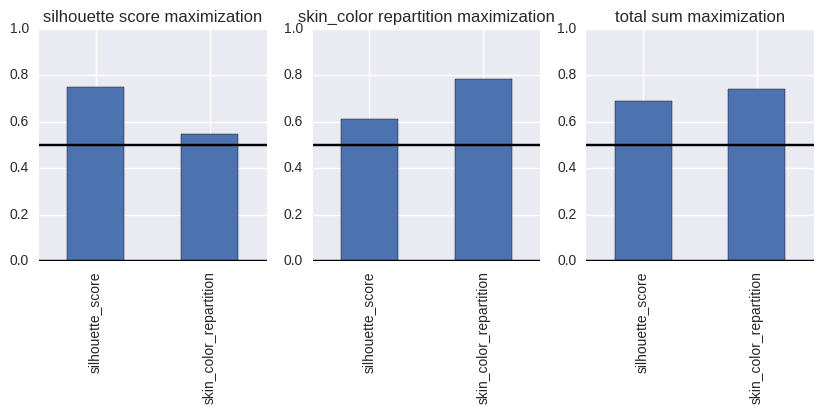

In [11]:
plt.figure()
plt.subplot(131)
ax = method_comparison['silhouette_score_maximization'].ix[0:2].plot(kind='bar', ylim=(0,1), figsize=(10,3), title='silhouette score maximization')
plt.axhline(0, color='k')
plt.axhline(0.5, color='k')
plt.subplot(132)
ax = method_comparison['skin_color_repartition_maximization'].ix[0:2].plot(kind='bar', ylim=(0,1), figsize=(10,3), title='skin_color repartition maximization')
plt.axhline(0, color='k')
plt.axhline(0.5, color='k')
plt.subplot(133)
ax = method_comparison['total_sum_maximization'].ix[0:2].plot(kind='bar', ylim=(0,1), figsize=(10,3), title='total sum maximization')
plt.axhline(0, color='k')
plt.axhline(0.5, color='k')
plt.show()

#### Results discussion
As expected, the silhouette score maximization led to a higher silhouette score, the skin color repartition score maximization led to a higher skin color repartition score and the total sum optimization led to something in between.

It can be noted that the silhouette score maximization used only one feature, 'leagueCountry' which makes sense since it's a feature that has discrete values and it should therefore be easy to separate in clusters. On the other hand, the skin color repartition score maximization used 12 different features to try to obatin the best separation between white and black people.

The results obatined in this optimization are not the best since it's just a naive algorithm and it has no guarentee to find the correct optimum, but the k_means calculations are quite costly and even this simple algorithm takes quite long to find its solution.

## Comparison of clustering with each feature separately
Since the best results obtained from the optimization use only one feature, we decided to do a comparison of the clustering for each feature alone to see their respective effect.

In [12]:
features_comparison = pd.DataFrame()
data_no_skin = data.drop(['skin_color'], axis=1)
for column in data_no_skin.columns: 
    s,c,w,b = kmeans(data[[column,'skin_color']])
    features_comparison[column] = pd.Series([s,c,w[0],b[0]])
features_comparison = features_comparison.set_index([['silhouette_score','skin_color_repartition','white_centroid','black_centroid']])
features_comparison

,club,leagueCountry,birthday,position,redCards,meanIAT_yellowCards,height,victories,meanIAT_yellowReds,meanIAT_redCards,games,weight,goals,meanExp_redCards,meanExp_yellowCards,meanExp_yellowReds,yellowCards,ties,defeats
silhouette_score,0.606468,0.751221,0.578957,0.613765,0.722772,0.566646,0.576066,0.635565,0.721717,0.677248,0.601649,0.565820,0.764072,0.691135,0.604789,0.730150,0.619241,0.586871,0.569149
skin_color_repartition,0.536998,0.548978,0.512333,0.529246,0.674419,0.560254,0.542636,0.661734,0.725159,0.715292,0.615927,0.546159,0.782946,0.742777,0.664553,0.734320,0.656096,0.603242,0.578576
white_centroid,18.520861,0.587786,7079.370757,1.630769,0.385199,-0.015193,187.275098,75.589118,-0.000689,-0.000780,167.874089,71.515513,17.927002,-0.005279,-0.011862,-0.000808,21.196226,39.358431,52.090909
black_centroid,58.630178,2.638231,4463.171516,7.531860,2.936986,0.028227,176.150307,220.317280,0.004167,0.003366,412.537118,83.120482,129.420690,0.030300,0.058615,0.006612,67.534819,96.943277,119.290135


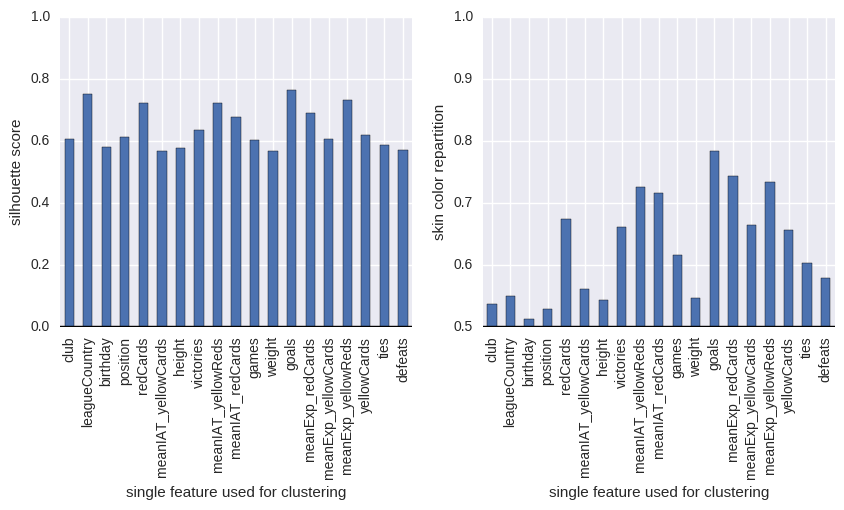

In [13]:
plt.figure()
plt.subplot(121)
row=features_comparison.ix[0]
ax = features_comparison.ix[0].plot(kind='bar', ylim=(0,1), figsize=(10,4))
ax.set(xlabel="single feature used for clustering", ylabel="silhouette score")
plt.axhline(0, color='k')
plt.subplot(122)
ax = features_comparison.ix[1].plot(kind='bar', ylim=(0.5,1), figsize=(10,4))
ax.set(xlabel="single feature used for clustering", ylabel="skin color repartition")
plt.axhline(0.5, color='k')
plt.show()

#### Results discussion
The results obtained with some features are better in both silhouette score and skin color repartition score than the results previously obtained by the optimization algorithm. It would be easy to conclude that black players do more goals in average than white players, or black players get more red cards than white people but the reality is the results are not significative at all. None of the skin color repartition scores exceed 0.84, which is the proportion of white people in the sample. That means that doing two clusters with one having everyone and the other having noone would result in 84% correct repartition of players and a skin color repartition score of 0.84, which is higher than any of the results obtained and does no separation at all.

To get a better feel of that conlcusion, the following steps analyze the detailed composition of the two clusters for the best feature found: 'goals'.

In [14]:
data_goals= data['goals'].to_frame()
kmeans_results = sklearn.cluster.k_means(data_goals, 2, init='k-means++', precompute_distances='auto', n_init=10, max_iter=300, verbose=False, tol=0.0001, random_state=None, copy_x=True, n_jobs=1, return_n_iter=True)
labels = kmeans_results[1]
silhouette_score = sklearn.metrics.silhouette_score(data_goals, labels)
labels_series = pd.Series(labels)
comparison = labels_series == data['skin_color']
true = comparison[lambda x: x == True].size
false = comparison.size - true
if(true > false):
    white_centroid = kmeans_results[0][0]
    black_centroid = kmeans_results[0][1]
    skin_color_repartition = true/comparison.size
else:
    white_centroid = kmeans_results[0][1]
    black_centroid = kmeans_results[0][0]
    skin_color_repartition = false/comparison.size
res = pd.Series([silhouette_score, skin_color_repartition, white_centroid[0], black_centroid[0]]).to_frame()
res.columns = ['goals']
res = res.set_index([['silhouette score','skin color repartition','white centroid','black centroid']])
res

,goals
silhouette score,0.764072
skin color repartition,0.782946
white centroid,17.927002
black centroid,129.420690


In [15]:
skcol = data['skin_color'].reset_index()
skin_color_repartition_detailed = (skcol['skin_color'].map(str) + labels_series.map(str))
skin_color_repartition_detailed = skin_color_repartition_detailed.groupby(skin_color_repartition_detailed).count().to_frame()
skin_color_repartition_detailed.columns = ['number of people']
skin_color_repartition_detailed = skin_color_repartition_detailed.set_index([['white people in white cluster','white people in black cluster',
                      'black people in white cluster','black people in black cluster']])
skin_color_repartition_detailed

,number of people
white people in white cluster,1079
white people in black cluster,113
black people in white cluster,195
black people in black cluster,32


In [16]:
skrd = skin_color_repartition_detailed.copy()
total = skrd.iloc[0] + skrd.iloc[1] + skrd.iloc[2] + skrd.iloc[3]
total_white_cluster = skrd.iloc[0] + skrd.iloc[2]
total_black_cluster = skrd.iloc[1] + skrd.iloc[3]
totals = pd.DataFrame([total_white_cluster, total_black_cluster, total])
totals.columns = ['number of people']
totals = totals.set_index([['people in white cluster', 'people in black cluster', 'total']])
totals

,number of people
people in white cluster,1274
people in black cluster,145
total,1419


In [17]:

skin_color_repartition_stats = pd.DataFrame([(skrd.iloc[0]+skrd.iloc[3])/total, 
              skrd.iloc[0]/(skrd.iloc[0]+skrd.iloc[1]), skrd.iloc[3]/(skrd.iloc[2]+skrd.iloc[3]), 
             skrd.iloc[0]/(skrd.iloc[0]+skrd.iloc[2]), skrd.iloc[3]/(skrd.iloc[1]+skrd.iloc[3])])
skin_color_repartition_stats.columns = ['proportion']
skin_color_repartition_stats = skin_color_repartition_stats.set_index([['total people correctly assigned', 'white people correctly assigned', 'black people correctly assigned', 'proportion of white people in the white cluster', 'proportion of black people in the black cluster']])
skin_color_repartition_stats

,proportion
total people correctly assigned,0.782946
white people correctly assigned,0.905201
black people correctly assigned,0.140969
proportion of white people in the white cluster,0.846939
proportion of black people in the black cluster,0.220690


While the total proportion of people correctly assigned is 78%, it is because 90% of the people are assigned in the white cluster, which leads to 90% of white people correctly assigned. On the other hand the black cluster has only 145 people and only 22% of them are black. In fact most black people are also assigned to the white cluster. This clearly shows that the separation is as good as no separation and no conclusion on the effect of the feature can be made using this method.

## Conclusion
No useful results can be found using this unsupervised k_means clustering method for a few reasons. First, the algorithm is too slow to try every possible combination of features. Secondly, forcing the clustering on only two different clusters is a bad idea since there is obviously not only one archetype of white player and one archetype of black player. Having more clusters could have given better results.